In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
from sklearn.metrics import (confusion_matrix, classification_report, 
                           roc_auc_score, precision_recall_curve, 
                           average_precision_score)
import shap
warnings.filterwarnings("ignore")

In [2]:
def load_numerical_model(model_path):
    """Load numerical model with metadata"""
    try:
        model_data = joblib.load(model_path)
        if not isinstance(model_data, dict) or 'model' not in model_data:
            raise ValueError("Invalid model format - missing metadata")
        return (
            model_data['model'],
            model_data['feature_names'],
            model_data['scaler'],
            model_data['model_params']
        )
    except Exception as e:
        raise ValueError(f"Error loading model: {str(e)}")

In [4]:
def prepare_numerical_input(input_data, feature_names, scaler):
    """Prepare numerical input data for prediction"""
    try:
        # Convert dict to DataFrame if needed
        if isinstance(input_data, dict):
            input_df = pd.DataFrame([input_data])
        else:
            input_df = input_data.copy()
            
        # Ensure all expected features are present
        for feature in feature_names:
            if feature not in input_df.columns:
                input_df[feature] = 0  # Fill missing with 0
                
        # Reorder columns to match training data
        input_df = input_df[feature_names]
        
        # Scale the data
        if scaler:
            input_scaled = scaler.transform(input_df)
            return pd.DataFrame(input_scaled, columns=feature_names)
        return input_df
        
    except Exception as e:
        raise ValueError(f"Input preparation failed: {str(e)}")

In [6]:
def evaluate_model(model, X_test, y_test, feature_names):
    """Comprehensive model evaluation with interpretability"""
    print("\n=== Model Evaluation ===\n")
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Classification metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # ROC and Precision-Recall
    print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Average Precision Score: {average_precision_score(y_test, y_proba):.4f}")
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    
    # Feature Importance
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        importances = model.named_steps['classifier'].feature_importances_
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
        plt.title('Top 20 Feature Importances')
        plt.tight_layout()
        plt.show()
    
    # SHAP Explanations (for tree-based models)
    try:
        explainer = shap.TreeExplainer(model.named_steps['classifier'])
        shap_values = explainer.shap_values(X_test)
        
        plt.figure(figsize=(12, 6))
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type='bar')
        plt.title('SHAP Feature Importance')
        plt.show()
        
        # Example explanation
        print("\nGenerating example SHAP explanation...")
        example_idx = 0
        plt.figure(figsize=(12, 6))
        shap.force_plot(explainer.expected_value, shap_values[example_idx,:], 
                       X_test.iloc[example_idx,:], feature_names=feature_names)
        plt.title('SHAP Explanation for Example Transaction')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"\nCould not generate SHAP explanations: {str(e)}")

In [7]:
def main():
    MODEL_PATH = '../assets/fraud_detection_model_numerical.pkl'
    TEST_DATA_PATH = '../assets/preprocessed_fraud_dataset_numerical_only.csv'
    
    try:
        # 1. Load numerical model
        model, feature_names, scaler, model_params = load_numerical_model(MODEL_PATH)
        print("Numerical model loaded successfully")
        print(f"Model parameters: {model_params}")
        
        # 2. Load and prepare test data
        test_data = pd.read_csv(TEST_DATA_PATH)
        X_test_raw = test_data.drop('Fraud_Label', axis=1)
        y_test = test_data['Fraud_Label']
        
        # Prepare test data
        X_test = prepare_numerical_input(X_test_raw, feature_names, scaler)
        
        # 3. Evaluate model
        evaluate_model(model, X_test, y_test, feature_names)
        
        # 4. Example prediction with interpretation
        example_transaction = {
            'Transaction_Amount': 1500,
            'Account_Balance': 5000,
            'IP_Address_Flag': 1,
            'Previous_Fraudulent_Activity': 0,
            'Daily_Transaction_Count': 10,
            'Avg_Transaction_Amount_7d': 200,
            'Failed_Transaction_Count_7d': 3,
            'Transaction_Distance': 1500,
            'Risk_Score': 0.9,
            'Is_Weekend': 0,
            'Hour': 3,
            'DayOfWeek': 4,
            'Is_Night': 1,
            'Amount_to_Balance_Ratio': 0.3,  # 1500/5000
            'Amount_Deviation': 1300,       # 1500-200
            'High_Risk_Category': 1
        }
        
        print("\n=== Example Transaction ===")
        for k, v in example_transaction.items():
            print(f"{k}: {v}")
        
        prepared_input = prepare_numerical_input(example_transaction, feature_names, scaler)
        prediction = model.predict(prepared_input)[0]
        probability = model.predict_proba(prepared_input)[0, 1]
        
        print(f"\nPrediction: {'Fraud' if prediction == 1 else 'Legitimate'}")
        print(f"Fraud Probability: {probability:.4f}")
        
        if probability > 0.5:
            print("\nALERT: This transaction is highly likely to be fraudulent!")
        else:
            print("\nThis transaction appears legitimate.")
        
        # Generate SHAP explanation for this transaction
        try:
            explainer = shap.TreeExplainer(model.named_steps['classifier'])
            shap_values = explainer.shap_values(prepared_input)
            
            plt.figure(figsize=(12, 4))
            shap.force_plot(explainer.expected_value, shap_values[0,:], 
                          prepared_input.iloc[0,:], feature_names=feature_names)
            plt.title('SHAP Explanation for This Transaction')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"\nCould not generate SHAP explanation: {str(e)}")
            
    except Exception as e:
        print(f"\nError: {str(e)}", file=sys.stderr)
        sys.exit(1)

Numerical model loaded successfully
Model parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}

=== Model Evaluation ===

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     33933
           1       1.00      0.47      0.64     16067

    accuracy                           0.83     50000
   macro avg       0.90      0.74      0.77     50000
weighted avg       0.86      0.83      0.81     50000



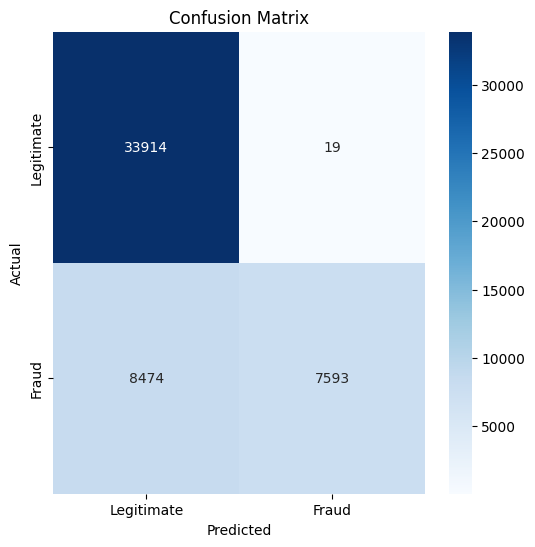


ROC-AUC Score: 0.8233
Average Precision Score: 0.7802


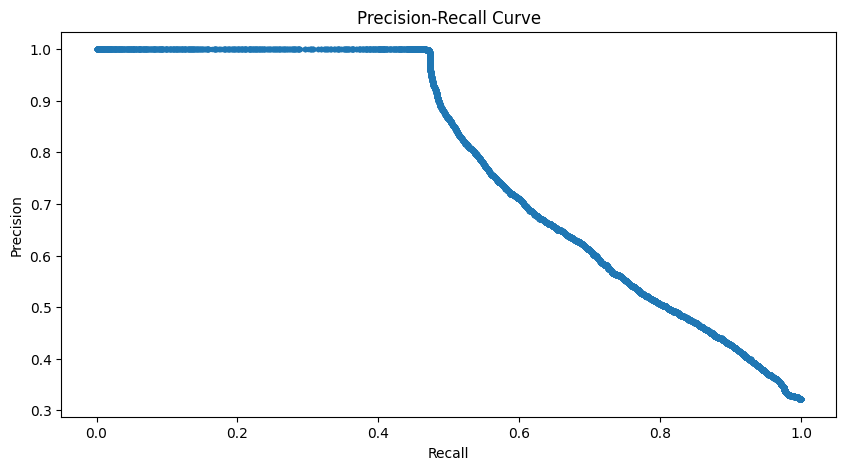

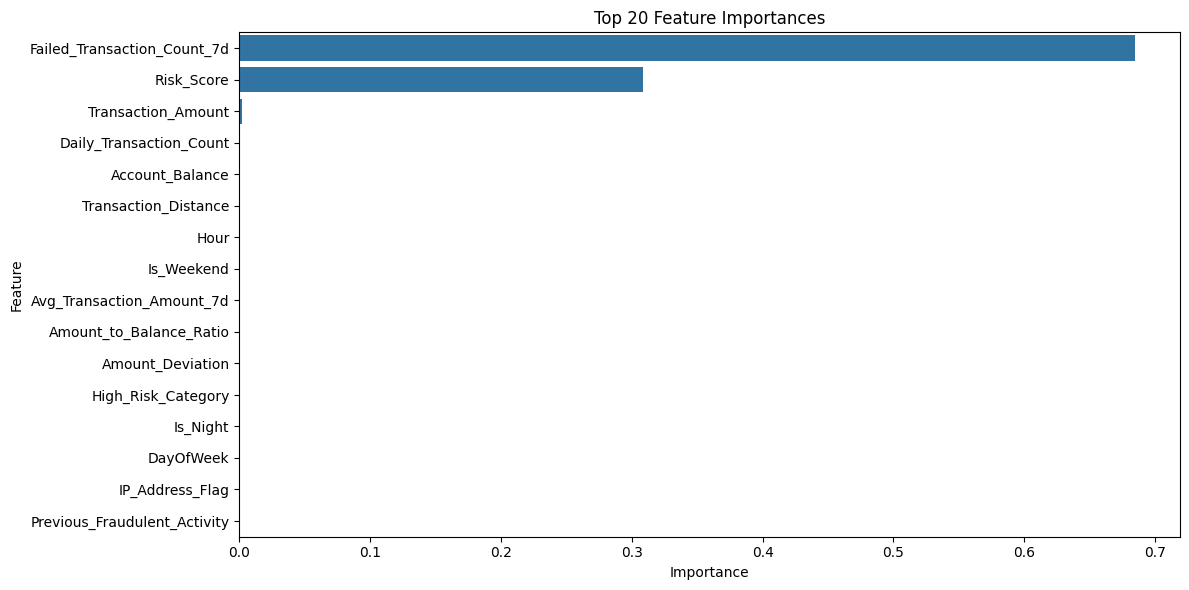

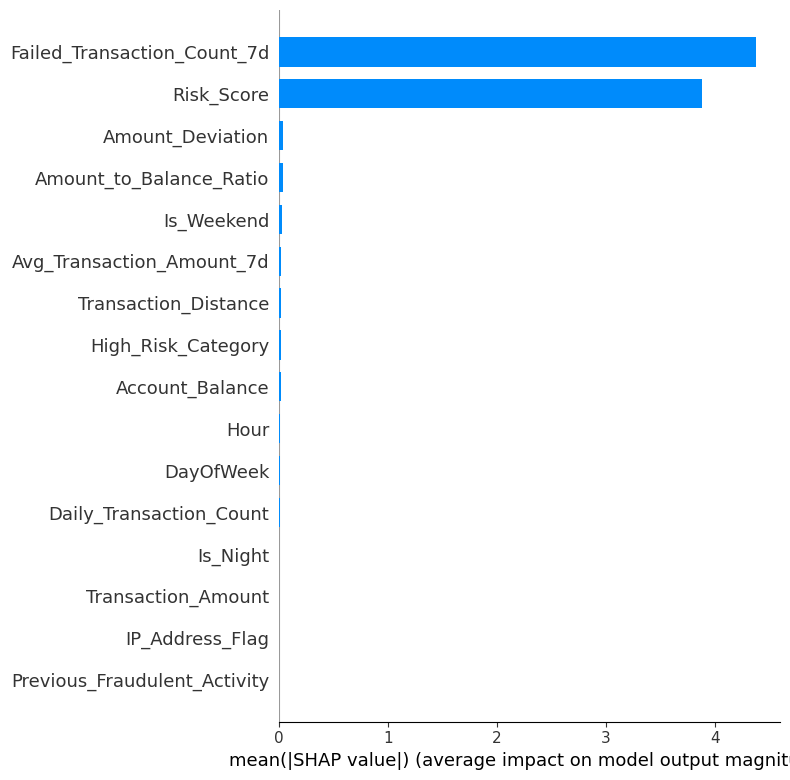

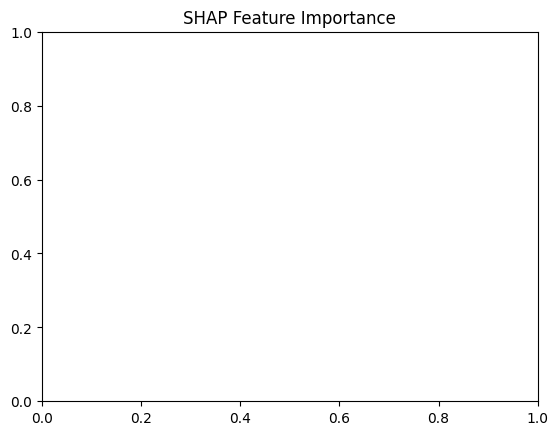


Generating example SHAP explanation...


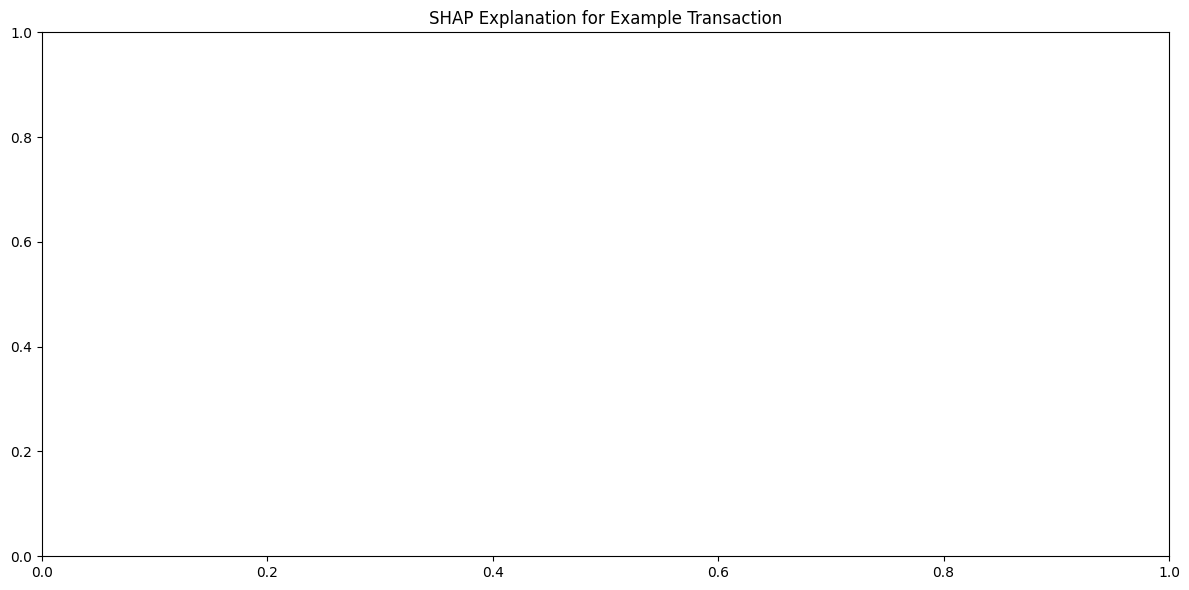


=== Example Transaction ===
Transaction_Amount: 1500
Account_Balance: 5000
IP_Address_Flag: 1
Previous_Fraudulent_Activity: 0
Daily_Transaction_Count: 10
Avg_Transaction_Amount_7d: 200
Failed_Transaction_Count_7d: 3
Transaction_Distance: 1500
Risk_Score: 0.9
Is_Weekend: 0
Hour: 3
DayOfWeek: 4
Is_Night: 1
Amount_to_Balance_Ratio: 0.3
Amount_Deviation: 1300
High_Risk_Category: 1

Prediction: Fraud
Fraud Probability: 0.9984

ALERT: This transaction is highly likely to be fraudulent!


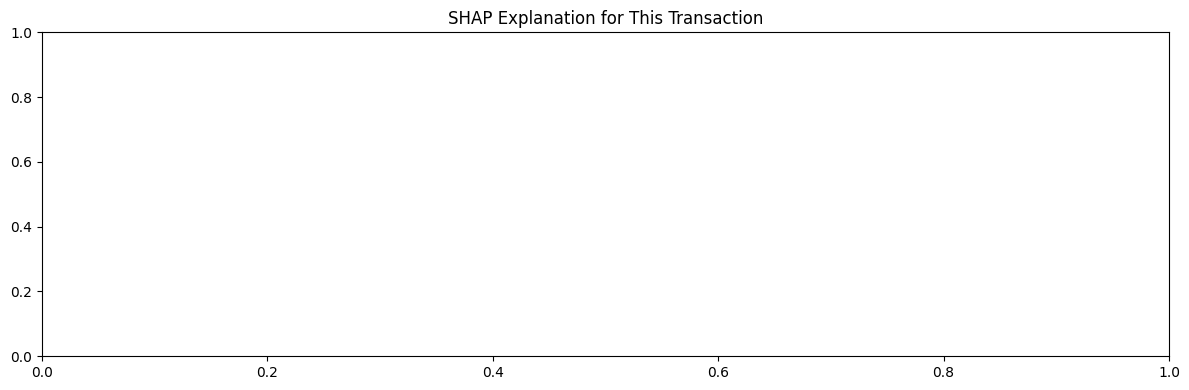

In [8]:
if __name__ == "__main__":
    main()